In [1]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn
from GeospatialFM.data import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {'exp_name': None,
        'config_file': 'GeospatialFM/configs/bigearthnet/bn_rn50_dino.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
args

Namespace(exp_name=None, config_file='GeospatialFM/configs/bigearthnet/bn_rn50_dino.yaml', opts=None, save_config=False, debug=True)

In [3]:
cfg, _ = setup(args)

In [4]:
cfg['DATASET']['kwargs'] = dict(bands='all', pad_s2=False)

In [5]:
train_ds, val_ds, test_ds = get_datasets(cfg['DATASET'])
# training_args = TrainingArguments(**cfg['TRAINER'])
# model = construct_model(cfg['MODEL'])
# compute_metrics = get_eval_fn(cfg['DATASET'])

In [6]:
len(train_ds)

39341

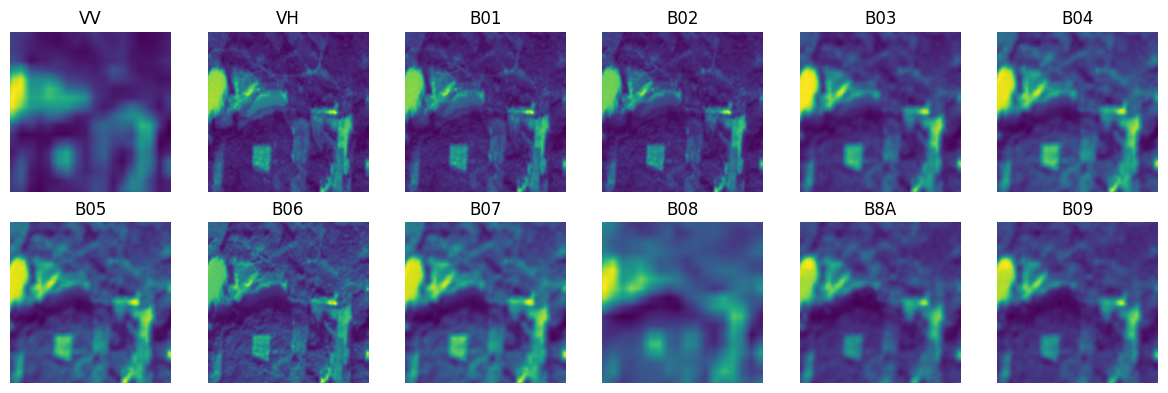

In [25]:
sample = train_ds[1]['image']
# visulize each channel of the image
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
channel_name = ['VV', 'VH', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(sample[i])
    ax.set_title(channel_name[i])
plt.tight_layout()  


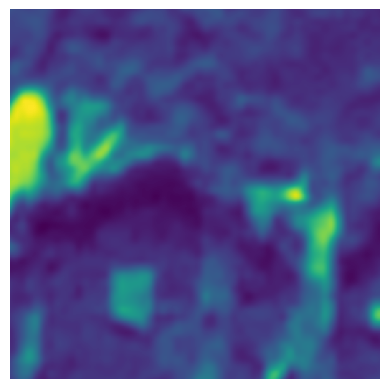

In [28]:
sample = train_ds[1]['image']
# visulize each channel of the image
# fig, axes = plt.subplots(3, 4, figsize=(12, 9))
# channel_name = ['VV', 'VH', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
# masked = np.random.choice(np.arange(12), 4, replace=False)
plt.axis('off')
plt.imshow(sample[11])
    # ax.set_title(channel_name[i])
# plt.tight_layout()  
# fig.subplots_adjust(hspace=0, wspace=0)

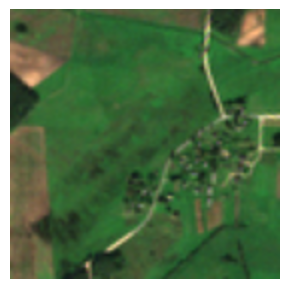

In [39]:
sample = train_ds[3]['image']
plt.figure(figsize=(3, 4))
plt.axis('off')
img = sample[[3, 2, 1]].permute(1, 2, 0)
# normalize the image
img = img / img.max()
plt.imshow(img)
# plt.title('RGB')
plt.tight_layout()  
# save as pdf
# plt.savefig('rgb.pdf', bbox_inches='tight', pad_inches=0)

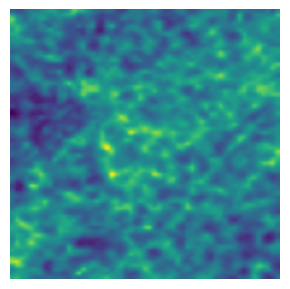

In [43]:
sample = train_ds[3]['radar']
plt.figure(figsize=(3, 4))
plt.axis('off')
img = sample[0]
# normalize the image
img = img / img.max()
plt.imshow(img)
# plt.title('RGB')
plt.tight_layout()  
# save as pdf

In [ ]:
gs = gridspec.GridSpec(2, 9)
fig = plt.figure(figsize=(18, 4))

# Plotting the large image which occupies 4 grid spaces
ax1 = fig.add_subplot(gs[0:2, 0:2])
img = sample[[5, 4, 3]].permute(1, 2, 0)
img = (img-img.min())/(img.max()-img.min())
ax1.imshow(img)
ax1.set_title('RGB')
ax1.axis('off')

# Plotting the other images in the remaining spaces
for x in range(2):
    for y in range(2, 9):
        i = y - 2 if x == 0 else y + 5    
        ax = fig.add_subplot(gs[x, y])
        ax.imshow(sample[i])
        ax.set_title(channel_name[i])
        ax.axis('off')

plt.tight_layout()
# plt.show()
plt.savefig('channels.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
img.min()

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

In [ ]:
# load the model.base_model's weights to segmentation model encoder
seg_model.encoder.load_state_dict(model.base_model.state_dict())

In [ ]:
seg_model.encoder.conv1.weight.data

In [ ]:
train_ds[0]['image'].shape

In [ ]:
train_ds[0]['label']

In [ ]:
ret = model(train_ds[0]['image'].unsqueeze(0).to(device))

In [ ]:
train_ds = ConcatDataset([train_ds, val_ds])
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=8)

In [ ]:
ret.shape

In [ ]:
trainer = Trainer(
    model=model,                # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_ds,    # training dataset
    eval_dataset=test_ds,      # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
def extract_features(model, dataloader, device):
    x_all = []
    y_all = []

    for batch in tqdm(dataloader):
        images = batch["image"].to(device)
        labels = batch["label"].numpy()
        
        with torch.inference_mode():
            features = model(images).cpu().numpy()
        
        x_all.append(features)
        y_all.append(labels)

    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    return x_all, y_all

In [ ]:
x_all, y_all = extract_features(model.base_model, train_dl, device)

In [ ]:
x_test, y_test = extract_features(model.base_model, test_dl, device)

In [ ]:
linear_model = LogisticRegression(C=50.0, max_iter=1000)
linear_model.fit(x_all, y_all)

In [ ]:
linear_model.score(x_test, y_test)

In [ ]:
model_cfg = cfg['MODEL']
model_cfg

In [ ]:
model = construct_model(model_cfg)

In [ ]:
model

In [ ]:
weights = tgm.get_weight(model_cfg['pretrained_ckpt'])
encoder = tgm.get_model(model_cfg['architecture'], weights=weights)

In [ ]:
encoder.head.in_features

In [ ]:
# get the last layer of the encoder
import timm

In [ ]:
timm.list_models('*dino*')

In [ ]:
224/14